## Goal: demo training ani on MD trajectories from ASE

In [1]:
import torch
import pandas as pd

from ase.io import read

from cascade.learning.torchani import TorchANI, estimate_atomic_energies
from cascade.learning.torchani.build import make_aev_computer, make_output_nets

import seaborn as sns
import matplotlib.pyplot as plt

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


In [2]:
traj = read('../0_setup/md/packmol-CH4-in-H2O=32-seed=0-blyp-npt=298/md.traj', 
            index=':')

In [3]:
ref_energies = estimate_atomic_energies(traj)
species = list(ref_energies.keys())
aev = make_aev_computer(species)
nn = make_output_nets(species, aev, 
                      # hidden_units=8, 
                      # hidden_layers=1,
                     )

In [4]:
ani = TorchANI()

In [5]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
device

'cuda'

In [6]:
#%%time
orig_e, orig_f = ani.evaluate((aev, nn, ref_energies), 
                              traj,
                              #batch_size=,
                              device=device)

In [7]:
%%time
model_msg, results = ani.train((aev, nn, ref_energies), 
                               traj[:400], traj[400:], 
                               50, 
                               device=device)

CPU times: user 3min 58s, sys: 142 ms, total: 3min 59s
Wall time: 3min 59s


In [8]:
results.head()

,iteration,e_rmse,e_mae,f_rmse,f_mae,split
0,0,0.360975,0.360975,0.508469,0.508469,train
1,1,0.369748,0.369748,0.486155,0.486155,train
2,2,0.570661,0.570661,0.463665,0.463665,train
3,3,0.506368,0.506368,0.451273,0.451273,train
4,4,0.682475,0.682475,0.438189,0.438189,train


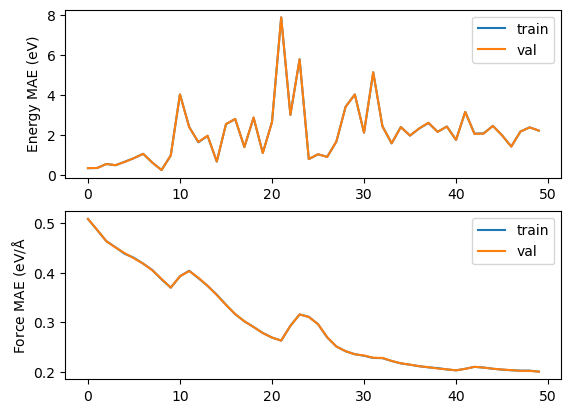

In [10]:
fig, axs = plt.subplots(2)

for split, marker in zip(['train', 'val'], ['x', 'o']):
    for i, quantity in enumerate(['e_mae', 'f_mae']):
        _df = results.query(f'split == "{split}"')
        axs[i].plot(_df['iteration'], 
                    _df[quantity], 
                    label=split, 
                    #marker=marker,
                   )

axs[0].set_ylabel('Energy MAE (eV)')
axs[0].legend()
axs[1].set_ylabel('Force MAE (eV/$\mathrm{\AA}$')
axs[1].legend()